#Libs

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

#Importing Kaggle API

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

100%|██████████| 5.20G/5.20G [00:36<00:00, 154MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2


#Viewing Folder Structure

In [ ]:
%cd /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2
%ls

/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2
ham10000_images_part_1/  HAM10000_images_part_2/  hmnist_28_28_RGB.csv
HAM10000_images_part_1/  HAM10000_metadata.csv    hmnist_8_8_L.csv
ham10000_images_part_2/  hmnist_28_28_L.csv       hmnist_8_8_RGB.csv


In [ ]:
dir_path = "/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2"

In [ ]:
df = pd.read_csv(dir_path + "/HAM10000_metadata.csv")

In [ ]:
# Count the number of each dx type
dx_counts = df['dx'].value_counts()
print(dx_counts)

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


#Data Preperation

##Mapping Image Paths and Lesion Types

This section prepares the dataset by creating mappings and preprocessing image data.

It includes:

<li>Creating a dictionary to map image IDs to their corresponding file paths.

<li>Defining a dictionary that maps lesion type abbreviations to their full descriptions for better readability.


<li>Establishing label mappings between numerical values and lesion types, for classification purposes.


<li>Updating the dataset by adding columns for lesion type descriptions, image file paths, and pixel data.


<li>Resizing all images to 32x32 pixels to ensure consistent input dimensions for the ML model.



In [ ]:
# Create a dictionary for image paths
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(dir_path, '*', '*.jpg'))}

# Map lesion types to their descriptions
lesion_type_dict = {
    'nv': 'Melanocytic nevi (nv)',
    'mel': 'Melanoma (mel)',
    'bkl': 'Benign keratosis-like lesions (bkl)',
    'bcc': 'Basal cell carcinoma (bcc)',
    'akiec': 'Actinic keratoses (akiec)',
    'vasc': 'Vascular lesions (vasc)',
    'df': 'Dermatofibroma (df)'
}

# Label mappings
label_mapping = {
    0: 'nv',
    1: 'mel',
    2: 'bkl',
    3: 'bcc',
    4: 'akiec',
    5: 'vasc',
    6: 'df'
}

# Used to swap label mapping from letters to numbers
reverse_label_mapping = dict((value, key) for key, value in label_mapping.items())

# Map lesion type descriptions and image paths to the DataFrame
df['cell_type'] = df['dx'].map(lesion_type_dict.get)
df['path'] = df['image_id'].map(imageid_path_dict.get)

# Resize images to 32x32 and map pixel data

df['image_pixel'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((32, 32))))

# Preview the DataFrame
print(df.sample(5))

        lesion_id      image_id     dx    dx_type   age     sex  \
6148  HAM_0002041  ISIC_0028532     nv  follow_up  35.0    male   
8815  HAM_0004534  ISIC_0024363     nv      histo  40.0    male   
9936  HAM_0006887  ISIC_0029500  akiec      histo  45.0    male   
1691  HAM_0004998  ISIC_0033651    mel      histo  60.0  female   
6616  HAM_0004825  ISIC_0028152     nv  follow_up  50.0    male   

         localization                  cell_type  \
6148          abdomen      Melanocytic nevi (nv)   
8815             back      Melanocytic nevi (nv)   
9936             face  Actinic keratoses (akiec)   
1691  lower extremity             Melanoma (mel)   
6616  upper extremity      Melanocytic nevi (nv)   

                                                   path  \
6148  /root/.cache/kagglehub/datasets/kmader/skin-ca...   
8815  /root/.cache/kagglehub/datasets/kmader/skin-ca...   
9936  /root/.cache/kagglehub/datasets/kmader/skin-ca...   
1691  /root/.cache/kagglehub/datasets/kmader/ski

#Exploratory Data Analysis

## Distribution of Dataset Attributes

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['Sex Distribution', 'Localization Distribution', 'Age Distribution', 'Lesion Type Distribution'],
    vertical_spacing=0.15,
    column_widths=[0.4, 0.6]
)

# Sex distribution
fig.add_trace(
    go.Bar(
        x=df['sex'].value_counts().index,
        y=df['sex'].value_counts(),
        marker_color='teal'
    ),
    row=1, col=1
)

# Localization distribution
fig.add_trace(
    go.Bar(
        x=df['localization'].value_counts().index,
        y=df['localization'].value_counts(),
        marker_color='purple'
    ),
    row=1, col=2
)

# Age distribution
fig.add_trace(
    go.Histogram(
        x=df['age'],
        marker_color='orange',
        nbinsx=20
    ),
    row=2, col=1
)

# Lesion type distribution
fig.add_trace(
    go.Bar(
        x=df['dx'].value_counts().index.map(lesion_type_dict.get),
        y=df['dx'].value_counts(),
        marker_color='blue'
    ),
    row=2, col=2
)

# Update y-axes titles
for i in range(4):
    fig.update_yaxes(title_text='Count', row=(i//2)+1, col=(i%2)+1)

# Update layout
fig.update_layout(
    title='Exploratory Data Analysis: Distribution of Attributes',
    height=800,
    showlegend=False,
    title_font_size=20
)

# Show the figure
fig.show()


##Lesion Samples

<ipython-input-10-d9db8b5c6362>:2: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



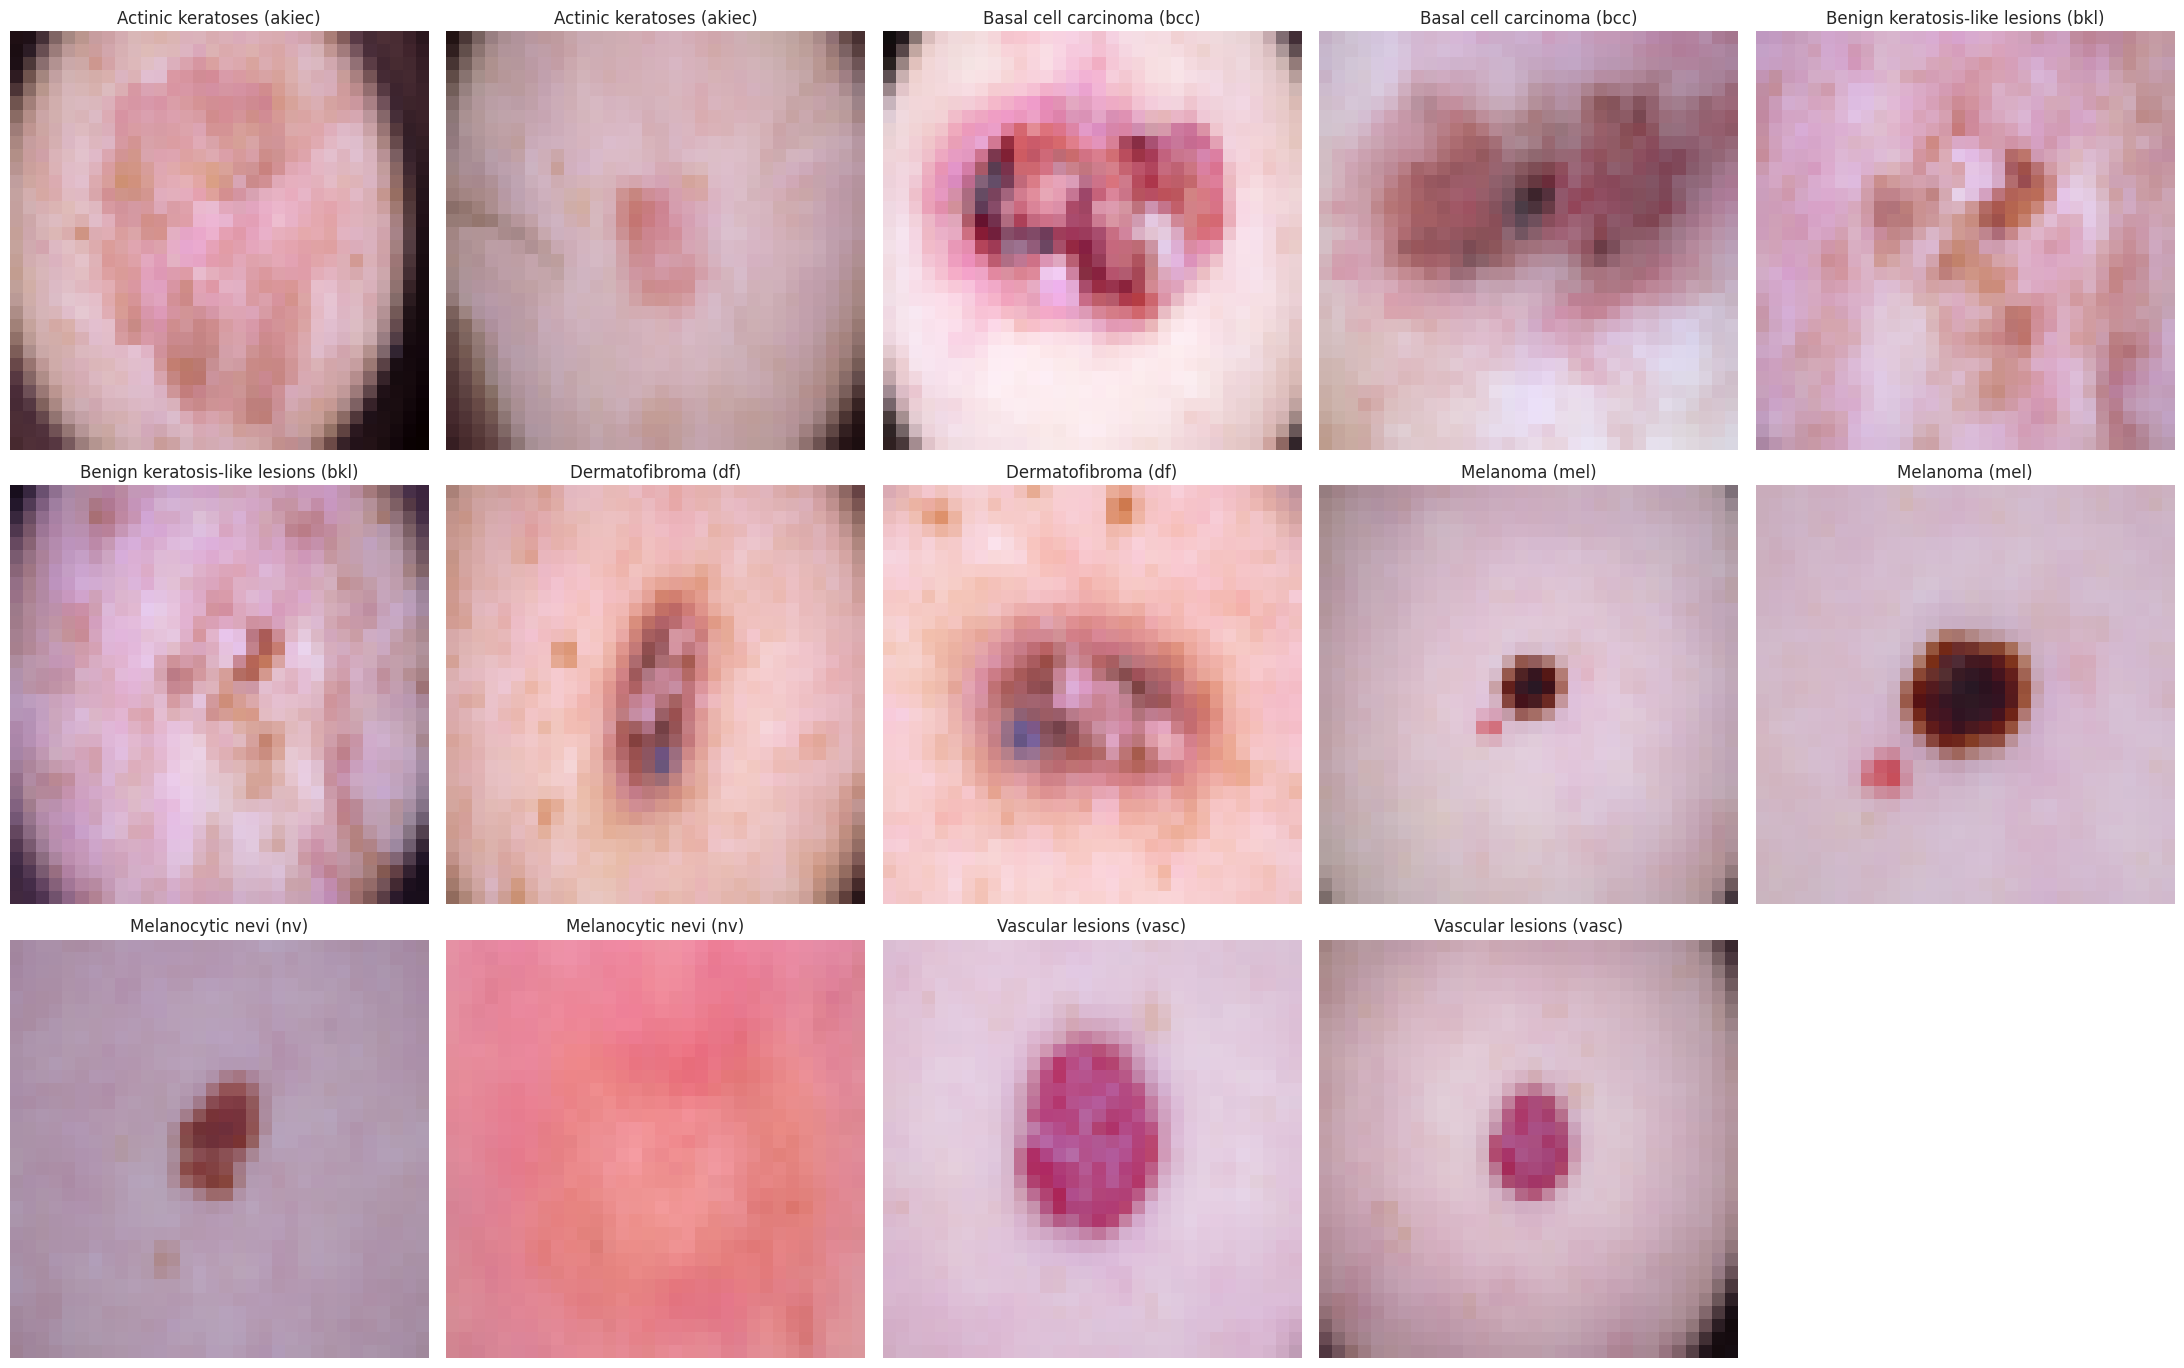

In [ ]:
# Grouping data to sample 2 images for each lesion type
sample_data = df.groupby('dx').apply(lambda x: x.iloc[:2]).reset_index(drop=True)

# Displaying the images
plt.figure(figsize=(22, 32))
for i in range(len(sample_data)):
    plt.subplot(7, 5, i + 1)
    plt.imshow(sample_data['image_pixel'][i].astype(np.uint8))  # Ensure image is displayed in correct format
    img_label = sample_data['cell_type'][i]  # Fetch  lesion label
    plt.title(img_label, fontsize=12)  # Set label as the title
    plt.axis("off")  # Hide axes

plt.tight_layout()
plt.show()


##Class Imbalance Check

<ipython-input-11-f421c06d21bd>:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




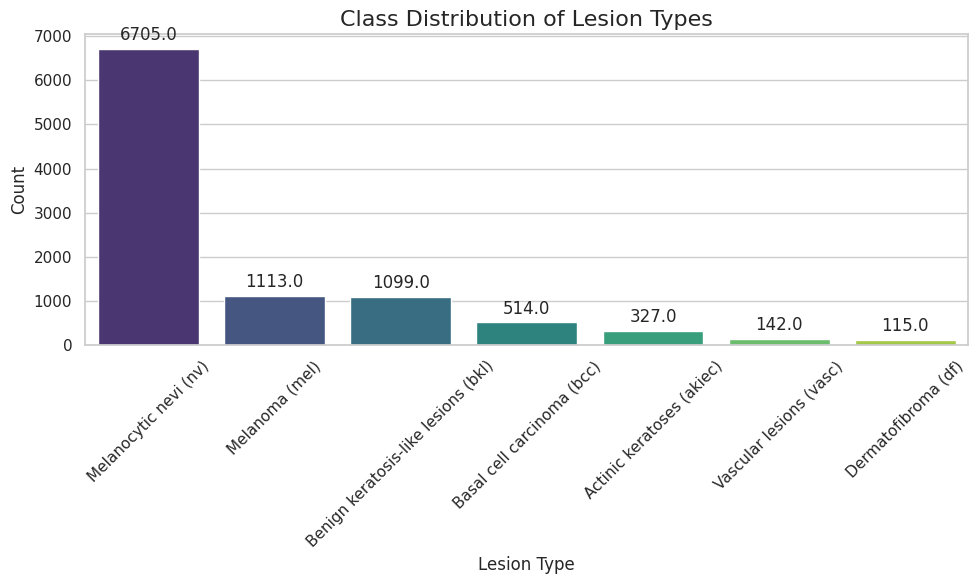

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style for the plot
sns.set(style="whitegrid")

# Plot lesion type distribution to check for imbalance
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='cell_type', data=df, palette='viridis', order=df['cell_type'].value_counts().index)

# Annotate bars with counts
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.title('Class Distribution of Lesion Types', fontsize=16)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Lesion Type', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#Preprocessing

## Null Value Handling

In [ ]:
# Display dataset information
print(df.info())

# Check for null values
print("Null values in each column:")
print(df.isnull().sum())

# Handle null values in the 'age' column by filling them with the mean age
df['age'].fillna(value=int(df['age'].mean()), inplace=True)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           10015 non-null  float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
 7   cell_type     10015 non-null  object 
 8   path          10015 non-null  object 
 9   image_pixel   10015 non-null  object 
dtypes: float64(1), object(9)
memory usage: 782.6+ KB
None
Null values in each column:
lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
cell_type       0
path            0
image_pixel     0
dtype: int64


<ipython-input-13-49905a982f2d>:9: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





##Encoding Categorical Labels

In [ ]:
# Convert the age column to integer
df['age'] = df['age'].astype('int32')

# Create a label column by mapping lesion types to numerical values
df['label'] = df['dx'].map(reverse_label_mapping.get)

# Display a sample
print(df.sample(5))

        lesion_id      image_id   dx    dx_type  age     sex     localization  \
7824  HAM_0007433  ISIC_0033149   nv      histo   45    male             back   
9136  HAM_0000778  ISIC_0026665   nv      histo   30  female             back   
3454  HAM_0000175  ISIC_0028356   nv  follow_up   40  female  lower extremity   
3831  HAM_0003114  ISIC_0032091   nv  follow_up   45  female             back   
1261  HAM_0004607  ISIC_0031642  mel      histo   50  female             back   

                  cell_type  \
7824  Melanocytic nevi (nv)   
9136  Melanocytic nevi (nv)   
3454  Melanocytic nevi (nv)   
3831  Melanocytic nevi (nv)   
1261         Melanoma (mel)   

                                                   path  \
7824  /root/.cache/kagglehub/datasets/kmader/skin-ca...   
9136  /root/.cache/kagglehub/datasets/kmader/skin-ca...   
3454  /root/.cache/kagglehub/datasets/kmader/skin-ca...   
3831  /root/.cache/kagglehub/datasets/kmader/skin-ca...   
1261  /root/.cache/kagglehub/da

#Data augmentation

Data augmentation is used to deal with class imbalance. Imbalanced data can cause machine learning models to become biased towards majority classes, resulting in poor generalisation. This section uses oversampling techniques to balance the dataset by increasing the number of instances in underrepresented classes.

##Oversampling Underrepresented Classes

Each class is duplicated a specific number of times using pd.concat to achieve a more balanced distribution.

In [ ]:
# Sorting and resetting the index for consistency
df = df.sort_values('label')
df = df.reset_index(drop=True)

# Identifying the indices for each label
index1 = df[df['label'] == 1].index.values
index2 = df[df['label'] == 2].index.values
index3 = df[df['label'] == 3].index.values
index4 = df[df['label'] == 4].index.values
index5 = df[df['label'] == 5].index.values
index6 = df[df['label'] == 6].index.values

# Creating subsets for each label
df_index1 = df.iloc[int(min(index1)):int(max(index1)+1)]
df_index2 = df.iloc[int(min(index2)):int(max(index2)+1)]
df_index3 = df.iloc[int(min(index3)):int(max(index3)+1)]
df_index4 = df.iloc[int(min(index4)):int(max(index4)+1)]
df_index5 = df.iloc[int(min(index5)):int(max(index5)+1)]
df_index6 = df.iloc[int(min(index6)):int(max(index6)+1)]

# Oversampling classes with underrepresentation using pd.concat
df_index1 = pd.concat([df_index1] * 5, ignore_index=True)
df_index2 = pd.concat([df_index2] * 5, ignore_index=True)
df_index3 = pd.concat([df_index3] * 12, ignore_index=True)
df_index4 = pd.concat([df_index4] * 18, ignore_index=True)
df_index5 = pd.concat([df_index5] * 46, ignore_index=True)
df_index6 = pd.concat([df_index6] * 53, ignore_index=True)

# Combining the original and augmented datasets
frames = [df, df_index1, df_index2, df_index3, df_index4, df_index5, df_index6]
final_data = pd.concat(frames, ignore_index=True)

# Before and after data shape
print(f"Original data shape: {df.shape}")
print(f"Augmented data shape: {final_data.shape}")



Original data shape: (10015, 11)
Augmented data shape: (45756, 11)


##Visualise distribution of data after augmentation

In [ ]:
# Visualising the distribution of data after augmentation
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=['Sex', 'Localization', 'Age', 'Skin Type'],
                    vertical_spacing=0.15,
                    column_widths=[0.4, 0.6])

fig.add_trace(go.Bar(
            x=final_data['sex'].value_counts().index,
            y=final_data['sex'].value_counts()),
            row=1, col=1)
fig.add_trace(go.Bar(
            x=final_data['localization'].value_counts().index,
            y=final_data['localization'].value_counts()),
            row=1, col=2)
fig.add_trace(go.Histogram(
            x=final_data['age']),
            row=2, col=1)
fig.add_trace(go.Bar(
            x=final_data['dx'].value_counts().index.map(lesion_type_dict.get),
            y=final_data['dx'].value_counts()),
            row=2, col=2)

# Adjusting layout and axes
for i in range(4):
    fig.update_yaxes(title_text='Count', row=i//2+1, col=i%2+1)

fig.update_layout(title='Distribution of Data after Augmentation', height=800)
fig.show()

#Model Preparation
process the dataset into a format suitable for TensorFlow, split it for training and testing, and build a CNN model that can accurately classify skin lesion images.

##Preparing Data

The image data and labels must be reshaped and formatted correctly.

The dataset is divided into training and testing sets to evaluate the model's performance on unseen data.

80% of the data is used for training the model.

20% is reserved for testing, providing a robust estimate of the models generalisation performance.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Prepare data
X = np.array([np.asarray(img).reshape(32, 32, 3) for img in final_data['image_pixel']])
y = np.array(final_data['label'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#Model Creation

Creating the CNN architecture using MobileNetV2 as the base model

In [ ]:
#Model Creation
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


# MobileNetV2 base model without the top classification layers.
base_model = MobileNetV2(input_shape=(32, 32, 3), include_top=False, weights=None)

# global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# fully connected layer and dropout
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)

# classification layer for 7 classes.
predictions = Dense(7, activation='softmax')(x)

# Construct the full model.
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model.
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print model summary.
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 16, 16, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 16, 16, 32)     │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 16, 16, 32)     │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 16, 16, 32)     │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 16, 16, 32)     │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 16, 16, 16)     │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 16, 16, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 16, 16, 96)     │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 16, 16, 96)     │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 16, 16, 96)     │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 17, 17, 96)     │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 8, 8, 96)       │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 2,388,743 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

#Model Training with Callbacks

In [ ]:
# Save the best model
checkpoint_cb = ModelCheckpoint("best_model.keras", save_best_only=True,
                                monitor='val_loss', mode='min', verbose=1)
# Stop training if validation loss doesn't improve for 5 epochs
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5,
                             restore_best_weights=True, verbose=1)
# Reduce learning rate when a plateau is reached
reduce_lr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 patience=3, verbose=1)


history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb]
)

Epoch 1/50
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4007 - loss: 1.5757
Epoch 1: val_loss improved from inf to 1.96471, saving model to best_model.keras
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 87s 35ms/step - accuracy: 0.4008 - loss: 1.5754 - val_accuracy: 0.1431 - val_loss: 1.9647 - learning_rate: 0.0010
Epoch 2/50
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6517 - loss: 0.9567
Epoch 2: val_loss did not improve from 1.96471
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - accuracy: 0.6517 - loss: 0.9567 - val_accuracy: 0.1431 - val_loss: 2.0047 - learning_rate: 0.0010
Epoch 3/50
1141/1144 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7187 - loss: 0.8123
Epoch 3: val_loss did not improve from 1.96471
1144/1144 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.7187 - loss: 0.8122 - val_accuracy: 0.1503 - val_loss: 1.9758 - learning_rate: 0.0010
Epoch 4/50
1142/1144 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7617 - loss: 0.7002
Epoch 4: val_loss improved from 1.

#Model Evaluation

##Accuracy

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")


286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9868 - loss: 0.0637
Test Accuracy: 98.77%


##Confusion Matrix

286/286 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
                                     precision    recall  f1-score   support

              Melanocytic nevi (nv)       1.00      0.92      0.96      1376
                     Melanoma (mel)       0.97      1.00      0.98      1324
Benign keratosis-like lesions (bkl)       0.97      1.00      0.98      1300
         Basal cell carcinoma (bcc)       0.99      1.00      0.99      1310
          Actinic keratoses (akiec)       1.00      1.00      1.00      1270
            Vascular lesions (vasc)       1.00      1.00      1.00      1319
                Dermatofibroma (df)       1.00      1.00      1.00      1253

                           accuracy                           0.99      9152
                          macro avg       0.99      0.99      0.99      9152
                       weighted avg       0.99      0.99      0.99      9152



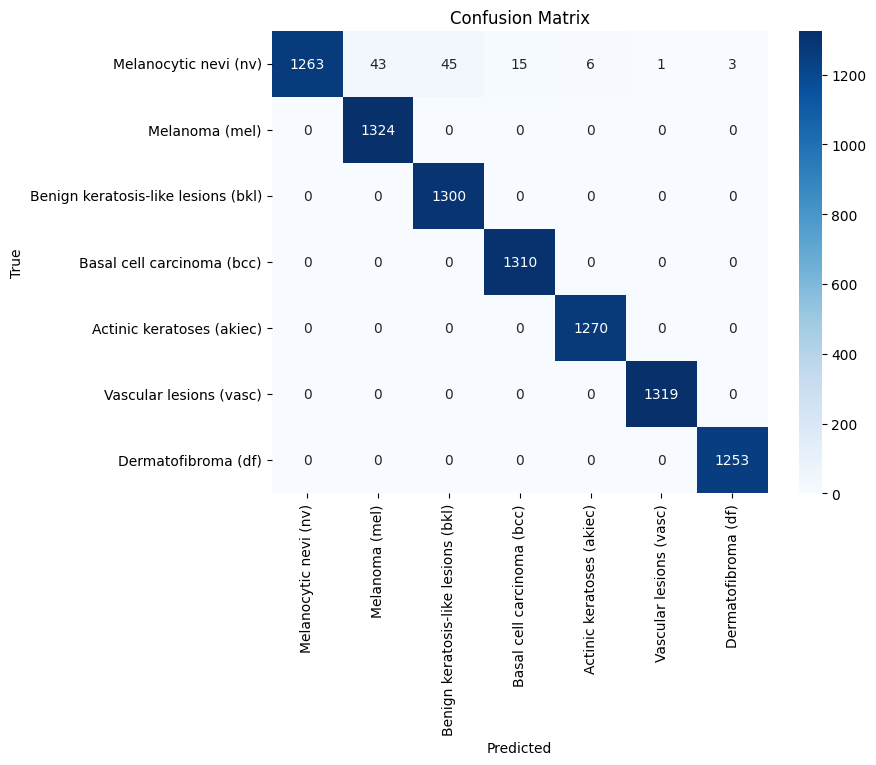

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predicting the labels for test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print(classification_report(y_test, y_pred_classes, target_names=list(lesion_type_dict.values())))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(lesion_type_dict.values()), yticklabels=list(lesion_type_dict.values()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


##Precision/Recall

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import label_binarize

# Compute overall precision and recall (using weighted averaging, for example)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")

Precision: 0.9880
Recall:    0.9877


In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred_classes, average='weighted')
print(f"F1-score: {f1:.4f}")


F1-score: 0.9875


##AUC-ROC

In [ ]:
n_classes = 7
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# 'y_pred' already contains the probability predictions for each class.
# Compute macro-average AUC-ROC using a one-vs-rest scheme.
auc_roc = roc_auc_score(y_test_bin, y_pred, average='macro', multi_class='ovr')
print(f"AUC-ROC:   {auc_roc:.4f}")

AUC-ROC:   0.9992


<ipython-input-20-61c7f9800844>:29: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



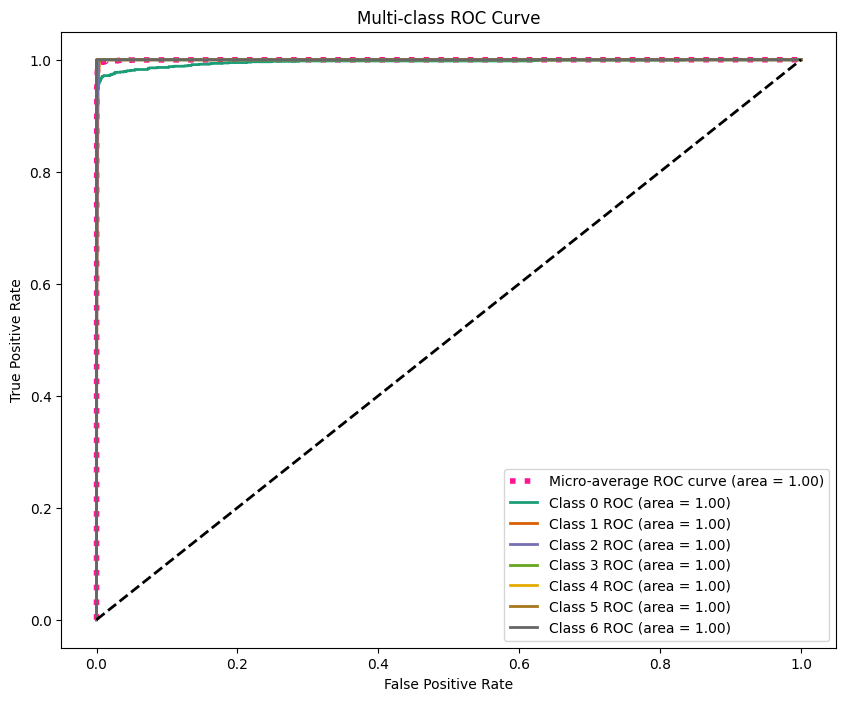

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

n_classes = 7
y_test_bin = label_binarize(y_test, classes=range(n_classes))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

colors = plt.cm.get_cmap('Dark2', n_classes)
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
             label=f'Class {i} ROC (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve')
plt.legend(loc="lower right")
plt.show()


##Training History Visualisation

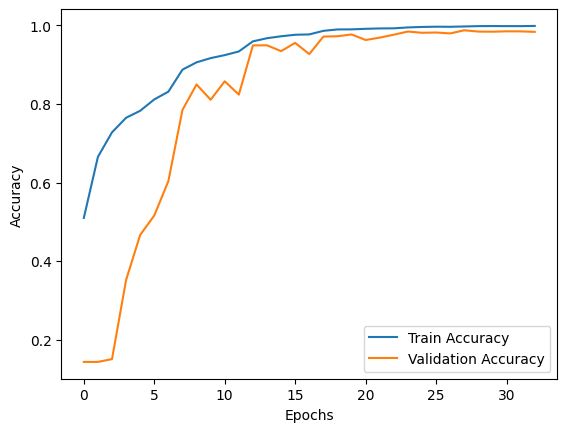

In [ ]:
import matplotlib.pyplot as plt

# Assuming you saved model history as 'history' during training
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#Converting CNN to TFLite

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import load_model

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

#  Load original Keras model
model = tf.keras.models.load_model('best_model.keras')

# Convert with optimizations
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # Optimize size
converter.allow_custom_ops = True
converter.target_spec.supported_types = [tf.float16]  # Use float16

# Convert model
tflite_model = converter.convert()

# Save model
#REDACTED PERSONAL INFO
#tflite_model_path = path
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved at: {tflite_model_path}")